#  ----------0712: I think there are something wrong with the comb noise or whatever.

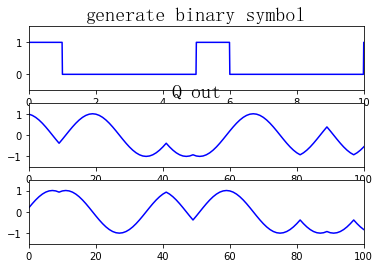

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [43]:
# coding: utf-8

# In[62]:


'''
this version use an easy CNN to demodulate MSK.
https://www.codercto.com/a/38746.html
the structure of CNN is:
reshape--conv--conv--maxpool--conv--conv--maxpool--GlobalAveragePooling--dropout--dense--
-----------Tan --------------------2019.03.09--------------------
-----------this version successed on 2019-3-13----------------
------with 8dB BER=0.01----------------------
-----modified on 2019.03.14------add different snr to see the BER curve---------haven't test----------
------2019.03.15 test this model, it is trained succesfully, but may be the test change the parameters of the 
model, but I don't know which sentence changed. or the 'add noise' sentence have some bugs------
------------------20190330------------------
------add carrier ----------------------------
--------20190513-----------------------
------change the structure of CNN------------------
'''
import matplotlib.pyplot as plt
import numpy as np 
from math import pi
from scipy import interpolate 
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as signal
import math
from scipy.stats import levy_stable
import CommFunc as CF
from keras.utils import np_utils

#----------import my function-----------
import noise
import comb_noise as cmbn

# get the train and test data
# generate symbol

data_len=1000
sample_num=8
Rb=100
fc=20000
sampling_t=0.01
t=np.arange(0,data_len,sampling_t)
multi=int(fc/Rb)
def symbol_out(data_len):
  a = np.random.randint(0, 2, data_len)
  m = np.zeros(len(t), dtype=np.float32)
  for i in range(len(t)):
    m[i] = a[math.floor(t[i])]
  for i in range(len(a)):
    if a[i]>0:
      a[i]=a[i]
    else:
      a[i]=-1
  return a,m
data,data_p=symbol_out(data_len)
# 解决set_title中文乱码
 
zhfont1 = matplotlib.font_manager.FontProperties(fname = 'C:\Windows\Fonts\simsun.ttc')
#------plot figure----------
fig = plt.figure() 
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_title('generate binary symbol', fontproperties = zhfont1, fontsize = 20)
 
plt.axis([0, 10, -0.5, 1.5])
 
plt.plot(t, data_p, 'b')

#---------- I and Q---------
def IQ_msk(data,data_len,sample_num,Rb):
    Tb=1/Rb
    #fs=Rb*sample_num
    # sampling
    data_sample=np.zeros(data_len*sample_num)
    count=0
    for i in range(data_len):
      data_sample[count:(i+1)*sample_num+1]=data[i]
      count=(i+1)*sample_num+1
    # phase
    phase=np.zeros(data_len*sample_num)
    phase[0]=data_sample[0]*pi/2/sample_num
    for i in range(1,data_len*sample_num):
      phase[i]=phase[i-1]+data_sample[i-1]*pi/2/sample_num
    I_out=np.cos(phase)
    Q_out=np.sin(phase)
    return I_out,Q_out
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
#-------plot figure--------------
ax2=fig.add_subplot(3,1,2)
ax2.set_title('I out', fontproperties = zhfont1, fontsize = 20)
plt.axis([0, 100, -1.5, 1.5])
plt.plot(I_out, 'b')
ax3=fig.add_subplot(3,1,3)
ax2.set_title('Q out', fontproperties = zhfont1, fontsize = 20)
plt.axis([0, 100, -1.5, 1.5])
plt.plot(Q_out, 'b')
plt.show()
#---modulate to defined frequency-----
def carriermod(fc,Rb,I_out,Q_out):
    pass
    multi = fc/Rb
    x_I=np.linspace(0,len(I_out)-1,len(I_out))
    x_Itemp=np.linspace(0,len(I_out)-1,(len(I_out)*multi))
    f_I = interpolate.interp1d(x_I,I_out,kind="slinear")
    I_temp=f_I(x_Itemp)
    x_Q=np.linspace(0,len(Q_out)-1,len(Q_out))
    x_Qtemp=np.linspace(0,len(Q_out)-1,(len(Q_out)*multi))
    f_Q = interpolate.interp1d(x_Q,Q_out,kind="slinear")
    Q_temp=f_Q(x_Qtemp)


    fs=fc*sample_num
    ts = np.arange(0, (len(I_temp)* 1) / fs, 1 / fs)
    signal_I=I_temp*np.cos(np.dot(2*pi*fc,ts))
    signal_Q=Q_temp*np.sin(np.dot(2*pi*fc,ts))

    signal_mod=signal_I-signal_Q
    return signal_mod
signal_mod=carriermod(fc,Rb,I_out,Q_out)

# input shape 16*100

In [44]:
#--------------prepare the convolutional neural network-------------
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils
print ('the library of the network has been prepared')



the library of the network has been prepared


In [99]:
#-------------define the number of classes of the signal (means 0/1 )--------
num_classes = 2
#-----------construct the 1D CNN-----------------------
# 1D CNN neural network
#input_shape = (sample_num*2,2)
model_m = Sequential()
#model_m.add(Reshape((sample_num, 2), input_shape=(input_shape)))
model_m.add(Reshape((sample_num*2, 100), input_shape=(1600,)))
model_m.add(Conv1D(200, 5, activation='relu', input_shape=(sample_num*2,100)))
#model_m.add(Conv1D(200, 4, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(160, 5, activation='relu'))
#model_m.add(Conv1D(160, 4, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())


# In[66]:


#------------compile the CNN--------------
model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
print('the model has been compiled')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 12, 200)           100200    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 6, 200)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2, 160)            160160    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 160)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 322       
Total para

In [112]:
#------------prepare combine noise-------------------
yita = 0  #yita = imnoise/combine noise
EbN0 = -6 # -6 #-4 #0 #6   #15
fs = fc*sample_num
cmb_noise = cmbn.combnoise(EbN0,yita,len(signal_mod),fc,fs)
print(cmb_noise)
im_noise=cmbn.imnoise(EbN0,yita,signal_mod.shape,alpha=1.2)  #alpha=1.2
print(im_noise)
signal_mod0 = signal_mod+cmb_noise+im_noise
#X_train = signal_mod0.reshape(data_len,sample_num,200)
print('the noise has been prepared')
print('the shape of comb noise',cmb_noise.shape)
#------prpare the data-+---------------
X_train=np.zeros((data_len,1600))
X_test=np.zeros((data_len,1600))
X_train = signal_mod0.reshape(data_len,1600) 

data_0=(data+1)/2

#X_train_pre=signal_mod
y_train = np_utils.to_categorical(data_0, num_classes=2)
print('y_train',y_train)
#print('data_0',data_0)
y_test=y_train
#X_train = X_train_pre.reshape(data_len,sample_num*multi)
X_test=X_train


print ('signals has been prepared')
print('shape of X_train',X_train.shape,'shape of y_train',y_train.shape)


[ 9.97703264e-01 -1.17121356e+00  6.16574002e-17 ... -9.21792102e-01
  1.60674773e-10 -1.69427818e-01]
[-0.  0.  0. ... -0. -0.  0.]
the noise has been prepared
the shape of comb noise (1600000,)
y_train [[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
signals has been prepared
shape of X_train (1000, 1600) shape of y_train (1000, 2)


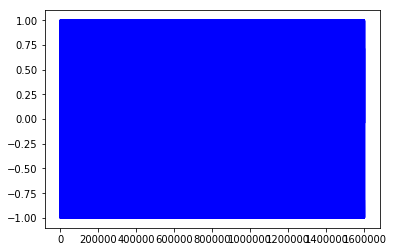

In [110]:
plt.figure
plt.plot(signal_mod,'b-')
plt.show()


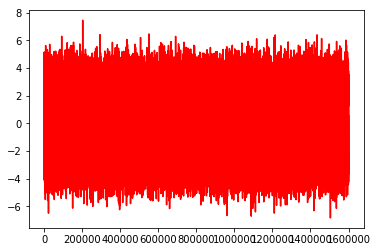

In [113]:
plt.figure
plt.plot(signal_mod0,'r-')
plt.show()

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 0s 108us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 2.5703e-04 - val_acc: 1.0000
Epoch 2/50
800/800 [==============================] - 0s 101us/step - loss: 0.0056 - acc: 0.9988 - val_loss: 2.2002e-04 - val_acc: 1.0000
Epoch 3/50
800/800 [==============================] - 0s 108us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.8137e-04 - val_acc: 1.0000
Epoch 4/50
800/800 [==============================] - 0s 101us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.3140e-04 - val_acc: 1.0000
Epoch 5/50
800/800 [==============================] - 0s 105us/step - loss: 0.0043 - acc: 0.9988 - val_loss: 9.0213e-05 - val_acc: 1.0000
Epoch 6/50
800/800 [==============================] - 0s 101us/step - loss: 0.0023 - acc: 0.9988 - val_loss: 6.9538e-05 - val_acc: 1.0000
Epoch 7/50
800/800 [==============================] - 0s 102us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 5.4840e-05 - val_

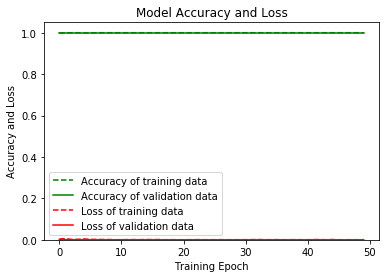

save model


In [114]:
##-----------the training parameters---------------
# Hyper-parameters
BATCH_SIZE = 500
EPOCHS = 50
#for i in range(2):
#    X_train[0:data_len,0:sample_num,i]= X_train[0:data_len,0:sample_num,i] +im_noise[0,0:data_len,0:sample_num]
    #X_test[0:data_len,0:sample_num,i]= X_test[0:data_len,0:sample_num,i] +im_noise[7,0:data_len,0:sample_num]
#X_test=X_test+im_noise
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                  #    callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
                     

# %%
#score = model_m.evaluate(X_test, y_test, verbose=1)
#print("\nAccuracy on test data: %0.2f" % score[1])
#print("\nLoss on test data: %0.2f" % score[0])
print("\n--- Learning curve of model training ---\n")
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model_m.save('CNN_comb_tr-6dB.h5')
print('save model')

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


data_0 [1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0

E:\Anaconda3\lib\site-packages\matplotlib\ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


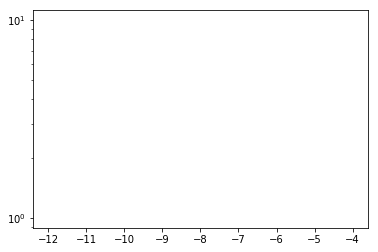

save txt have done


In [115]:
#-------------load the model-------------
from keras.models import load_model 

#------test data generating---------------
data,data_p=symbol_out(data_len)
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
signal_mod=carriermod(fc,Rb,I_out,Q_out)
#--generate noise--------------


#X_train = signal_mod0.reshape(data_len,sample_num,200)

#signal_mod0 = signal_mod + im_noise

data_0=(data+1)/2
print('data_0',data_0)
Y_test = np_utils.to_categorical(data_0, num_classes=2)
print('Y_test',Y_test)


#*************alpha=1.5*******************************************
model2 = model_m
#-----test and plot----------
#---plot ber curve-------------
yita = 0
EbN0 = [-12,-11,-10,-9,-8,-7,-6,-5,-4] #[-5,-4,-3,-2,-1,0,1,2,3] #[-8,-7,-6,-5,-4,-3,-2,-1,0]  #[1,2,3,4,5] # 
BER = [0]*len(EbN0)
loop_num = [1]*len(EbN0)    #[1,1,10,10,10,10,100,100,1000]
for i in range(len(EbN0)):
  #EbN0[i] = GSNR[i]/2
  cmb_noise = cmbn.combnoise(EbN0[i],yita,len(signal_mod),fc,fs)
  im_noise=cmbn.imnoise(EbN0[i],yita,signal_mod.shape,alpha=1.2)
  signal_mod0 = signal_mod+cmb_noise+im_noise
  X_test = signal_mod0.reshape(data_len,1600) 
  BER_loop = [0]*loop_num[i]
  wrong = [0]*loop_num[i]
  wrong_sum = 0
  for loop in range(loop_num[i]):
    
    loss,accuracy = model2.evaluate(X_test, Y_test)
    BER_loop[loop] = 1- accuracy
    wrong[loop] = BER_loop[loop]*data_len
  wrong_sum = sum(wrong)
  BER[i] = wrong_sum/(data_len*loop_num[i])
  print('BER',BER[i])
plt.semilogy(EbN0,BER,'b*-')
plt.savefig('BER_MSK_GCNN_tr2dBv8_te_5_2dB_alpha12.jpg')
plt.show()
np.savetxt('BER_MSK_GCNN_tr-6dBv8_te_12_4_comb.txt',BER,fmt='%0.8f')
print('save txt have done')

In [13]:
print (y_train)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
